In [1]:
import os
import numpy as np
import torch

In [2]:
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def rotate_graph(xy):
    n = len(xy)
    xy_90 = np.zeros((n, 2))
    xy_180 = np.zeros((n, 2))
    xy_270 = np.zeros((n, 2))
    for i in range(n):
        xy_90[i, 0], xy_90[i, 1] = rotate((0.5, 0.5), xy[i], math.radians(90))
        xy_180[i, 0], xy_180[i, 1] = rotate((0.5, 0.5), xy[i], math.radians(180))
        xy_270[i, 0], xy_270[i, 1] = rotate((0.5, 0.5), xy[i], math.radians(270))
    return np.array([xy, xy_90, xy_180, xy_270])

In [3]:
def scale_graph(xy):
    return np.array([xy, xy/1.2, xy/2, xy*5])

In [4]:
from tsp_gurobi import solve_all_gurobi
import math

In [5]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_tsp(xy, tour, ax1):
    """
    Plot the TSP tour on matplotlib axis ax1.
    """
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    xs, ys = xy[tour].transpose()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    
    ax1.set_title('{} nodes, total length {:.2f}'.format(len(tour), lengths[-1]))

In [6]:
x = np.random.rand(100, 50, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from Attention import TSPSolver as Attention
attention = Attention()
attention.load("AT_Net_AttentionReinfRemPol2.pt")
attention.to(device)
xys = []
for i in range(100):
    xys.append(rotate_graph(x[i]))
    #xys.append(scale_graph(x[i]))
xys = np.array(xys)
xys = xys.reshape(-1, 50, 2)
res = solve_all_gurobi(x)
tours = []
lens = []
for i in range(len(xys)):
    xy = xys[i]
    X = torch.Tensor(xy)
    tour = attention.decode(X.unsqueeze(0).to(device), rollout=True)
    tour = tour[0].squeeze().cpu().numpy()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lens.append(d.sum())
    tours.append(tour)
    
tours_0 = []
lens_0 = []
for i in range(len(x)):
    xy = x[i]
    X = torch.Tensor(xy)
    tour = attention.decode(X.unsqueeze(0).to(device), rollout=True)
    tour = tour[0].squeeze().cpu().numpy()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lens_0.append(d.sum())
    tours_0.append(tour)

Solving instance 0
Set parameter Username
Academic license - for non-commercial use only - expires 2023-05-26
Solving instance 1
Solving instance 2
Solving instance 3
Solving instance 4
Solving instance 5
Solving instance 6
Solving instance 7
Solving instance 8
Solving instance 9
Solving instance 10
Solving instance 11
Solving instance 12
Solving instance 13
Solving instance 14
Solving instance 15
Solving instance 16
Solving instance 17
Solving instance 18
Solving instance 19
Solving instance 20
Solving instance 21
Solving instance 22
Solving instance 23
Solving instance 24
Solving instance 25
Solving instance 26
Solving instance 27
Solving instance 28
Solving instance 29
Solving instance 30
Solving instance 31
Solving instance 32
Solving instance 33
Solving instance 34
Solving instance 35
Solving instance 36
Solving instance 37
Solving instance 38
Solving instance 39
Solving instance 40
Solving instance 41
Solving instance 42
Solving instance 43
Solving instance 44
Solving instance 45

5.653623081401636


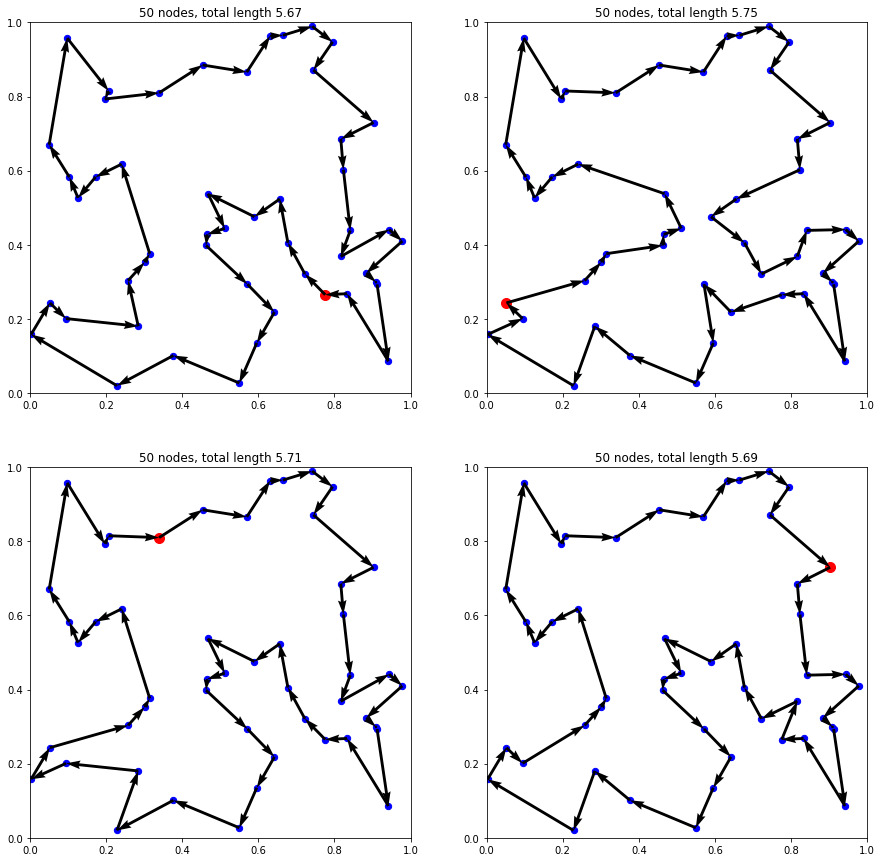

In [7]:
fig, axs = plt.subplots(2,2, figsize=(15, 15))
plot_tsp(xys[4], tours[4], axs[0,0])
plot_tsp(xys[4], tours[5], axs[0,1] )
plot_tsp(xys[4], tours[6], axs[1,0])
plot_tsp(xys[4], tours[7], axs[1,1] )
print(res[1][0])

In [8]:
len_opt = []
l = []
for i in range(len(res)):
    len_opt.append(res[i][0])
    l.append(np.min(lens[i*4:i*4+4]))

0.9300833336185967
2.2897429992558234


Text(0, 0.5, 'Optimality_gap %')

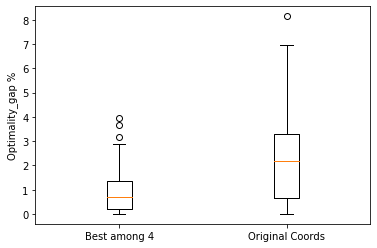

In [9]:
lens = np.array(l)
lens0 = np.array(lens_0)
#len_opt = np.array(l)
len_opt = np.array(len_opt)
gap = 100*(lens-len_opt)/len_opt
gap1 = 100*(lens0-len_opt)/len_opt
print(gap.mean())
print(gap1.mean())
plt.boxplot([gap, gap1])
plt.xticks([1,2], ['Best among 4','Original Coords'])
plt.ylabel('Optimality_gap %')

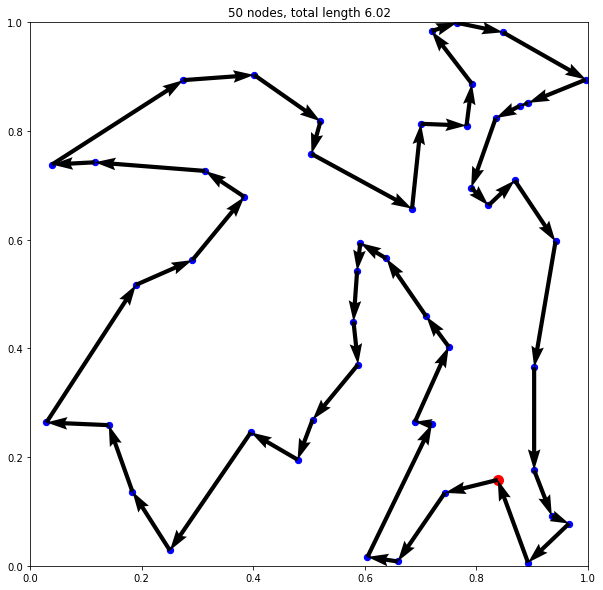

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_tsp(xy, tour, ax1):
    """
    Plot the TSP tour on matplotlib axis ax1.
    """
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    xs, ys = xy[tour].transpose()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    
    ax1.set_title('{} nodes, total length {:.2f}'.format(len(tour), lengths[-1]))
    
fig, ax = plt.subplots(figsize=(10, 10))
plot_tsp(xy, tour, ax)
